# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name: AhmadReza Nopoush**
- **Student ID: 610301194**

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [7]:
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3,1,1)
        self.std = torch.tensor(std).view(3,1,1)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        # YOUR CODE HERE

        if gray:
            tensor = tensor * self.std + self.mean
            tensor = tensor[0]*coeff[0] + tensor[1]*coeff[1] + tensor[2]*coeff[2]
            return tensor.unsqueeze(0)  # shape (1, H, W)
        else:
            return tensor * self.std + self.mean

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

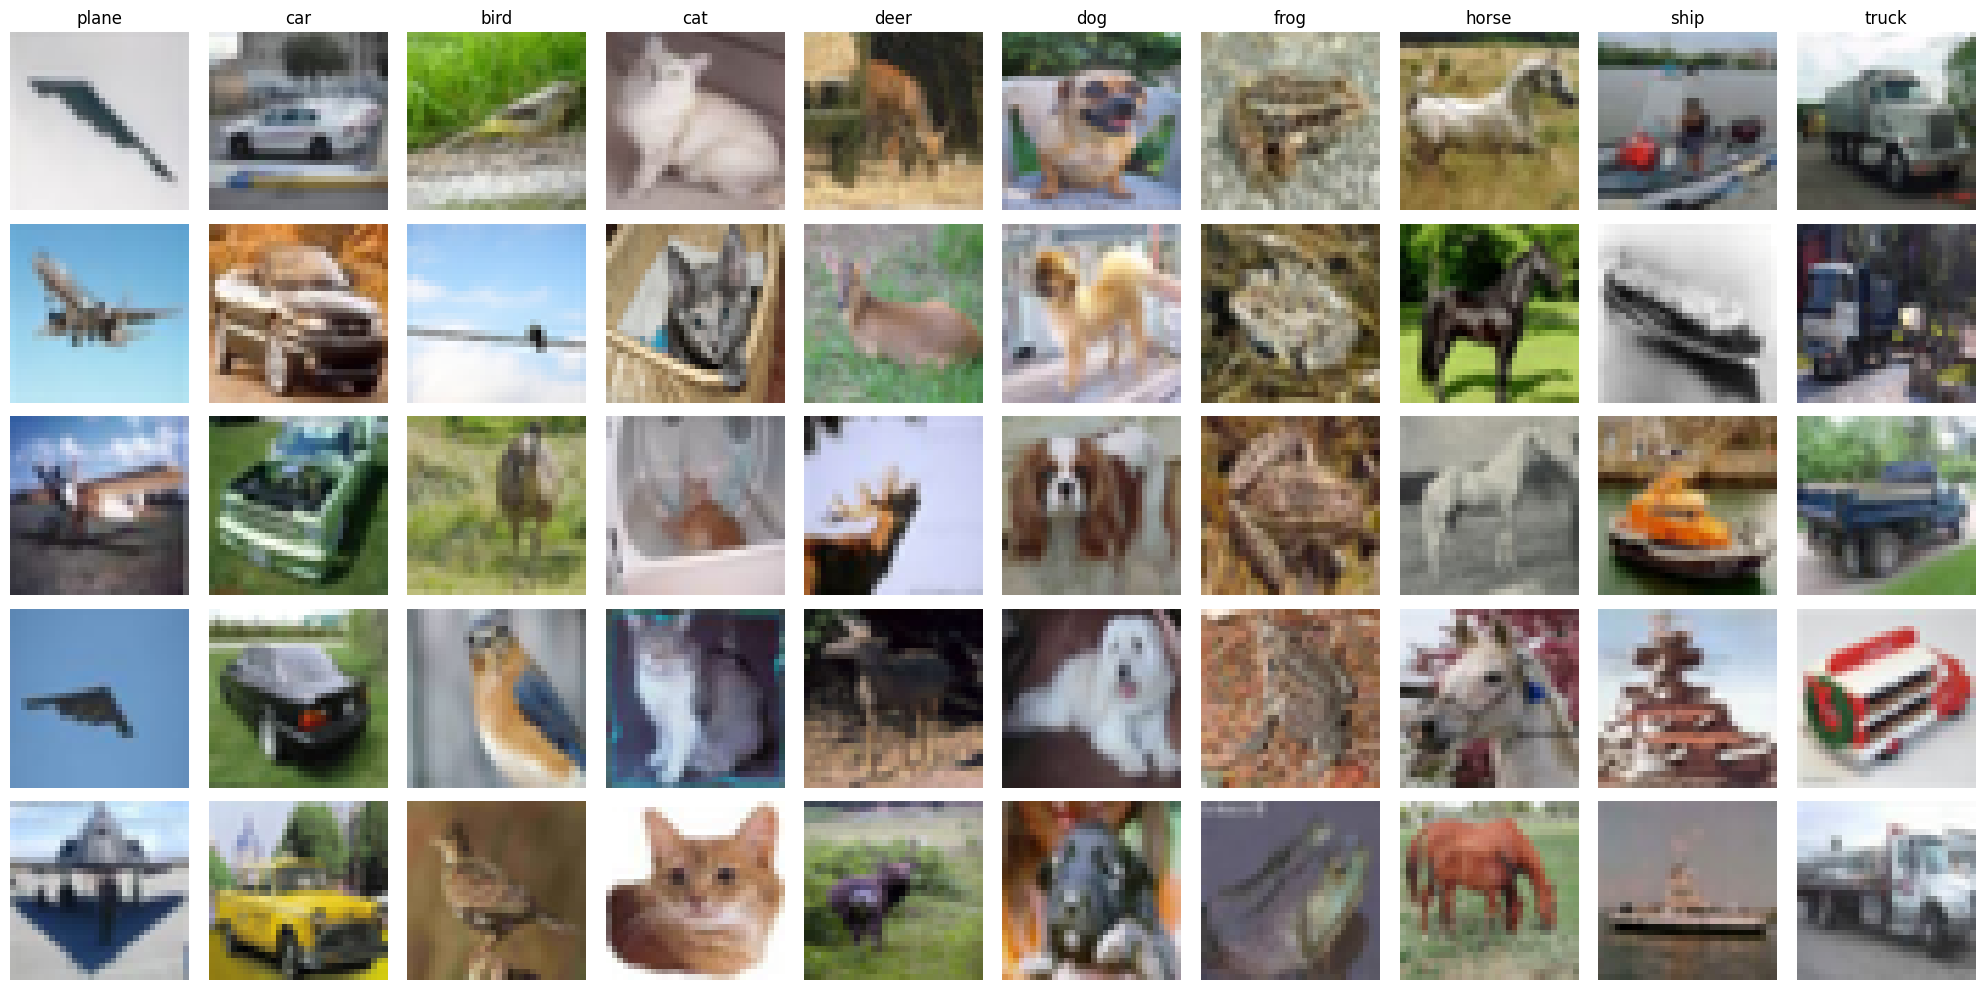

In [8]:
# YOUR CODE HERE

import matplotlib.pyplot as plt
import numpy as np
import random

def tensor_to_image(tensor):
    tensor = norminv(tensor)
    tensor = tensor.permute(1, 2, 0).numpy()
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Collect 5 images
samples_per_class = 5
class_to_images = {i: [] for i in range(10)}

for img, label in trainset:
    if len(class_to_images[label]) < samples_per_class:
        class_to_images[label].append(img)
    if all(len(images) == samples_per_class for images in class_to_images.values()):
        break

# Plotting
fig, axes = plt.subplots(samples_per_class, 10, figsize=(20, 10))

for class_idx in range(10):
    for sample_idx in range(samples_per_class):
        ax = axes[sample_idx, class_idx]
        img = tensor_to_image(class_to_images[class_idx][sample_idx])
        ax.imshow(img)
        ax.axis('off')
        if sample_idx == 0:
            ax.set_title(classes[class_idx])

plt.tight_layout()
plt.show()


# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [17]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()
        # YOUR CODE HERE

        input_dim = np.prod(input_shape)

        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(4096, 3072),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.linear = nn.Linear(1024, num_classes)

        #self.linear = nn.Linear # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE

        x = self.features(x)
        x = self.linear(x)
        return x

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

`WRITE YOUR ANSWER HERE`

3 * 32 * 32 * 4096 = 12582912

4096 * 3072 = 12582912

3072 * 2048 = 6291456

2048 * 1024 = 2097152

1024 * 10 = 10240

12582912 + 4096 + 12582912 + 3072 + 6291456 + 2048 + 2097152 + 1024 + 10240 + 10 = 33574922



Once you have completed your hand calculation, you can verify your result by running the following cell:

In [18]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 4096]      12,587,008
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 3072]      12,585,984
              ReLU-6                 [-1, 3072]               0
           Dropout-7                 [-1, 3072]               0
            Linear-8                 [-1, 2048]       6,293,504
              ReLU-9                 [-1, 2048]               0
          Dropout-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                   

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [19]:
model = None
# YOUR CODE HERE

model = FullyConnectedNetwork()
model.to(device)

FullyConnectedNetwork(
  (features): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=4096, out_features=3072, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=3072, out_features=2048, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=2048, out_features=1024, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.1, inplace=False)
  )
  (linear): Linear(in_features=1024, out_features=10, bias=True)
)

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [20]:
criterion = None # YOUR CODE HERE
optimizer = None # YOUR CODE HERE

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [21]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` updates the model's parameters based on the computed gradients to minimize the loss.
    """

    # YOUR CODE HERE

    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()

    # YOUR CODE HERE

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [22]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.8356; train acc: 33.86%; val loss: 1.6436; val_acc: 40.24%
(Epoch 2 / 60) train loss: 1.6031; train acc: 43.46%; val loss: 1.5795; val_acc: 44.06%
(Epoch 3 / 60) train loss: 1.5020; train acc: 47.15%; val loss: 1.4784; val_acc: 47.28%
(Epoch 4 / 60) train loss: 1.4481; train acc: 48.90%; val loss: 1.4481; val_acc: 48.18%
(Epoch 5 / 60) train loss: 1.3843; train acc: 51.34%; val loss: 1.4156; val_acc: 50.20%
(Epoch 6 / 60) train loss: 1.3412; train acc: 52.60%; val loss: 1.4095; val_acc: 50.98%
(Epoch 7 / 60) train loss: 1.3025; train acc: 54.06%; val loss: 1.3985; val_acc: 51.42%
(Epoch 8 / 60) train loss: 1.2592; train acc: 55.27%; val loss: 1.3715; val_acc: 53.08%
(Epoch 9 / 60) train loss: 1.2241; train acc: 56.78%; val loss: 1.3877; val_acc: 53.08%
(Epoch 10 / 60) train loss: 1.1963; train acc: 57.63%; val loss: 1.3754; val_acc: 52.96%
(Epoch 11 / 60) train loss: 1.1637; train acc: 58.79%; val loss: 1.3477; val_acc: 52.50%
(Epoch 12 / 60) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [23]:
torch.save(model.state_dict(), "fully-connected.pth")

In [24]:
# To load the previously saved model, simply uncomment the code below.
#model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

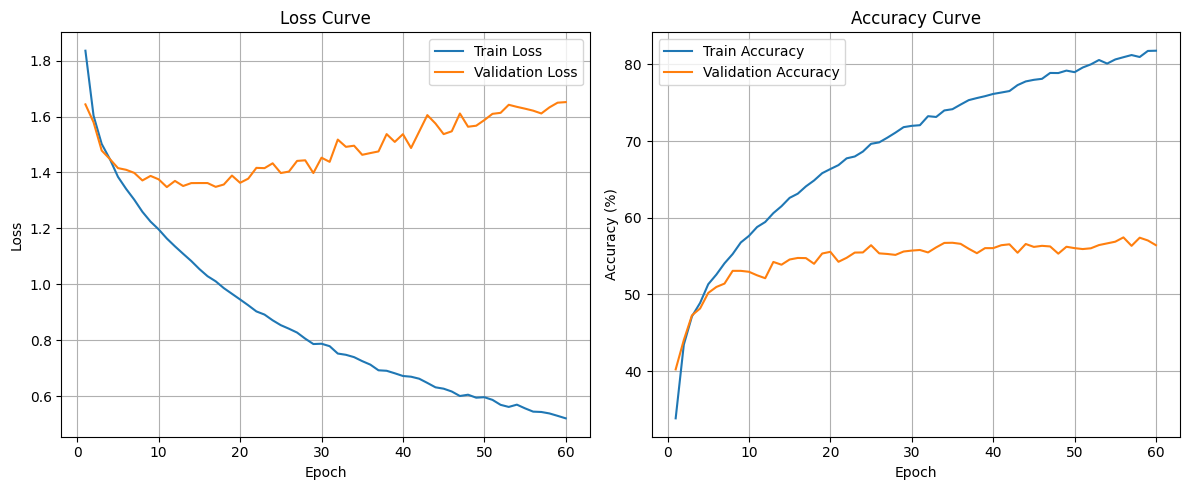

In [25]:
# YOUR CODE HERE

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [26]:
# YOUR CODE HERE

test_loss, test_acc = eval_epoch(model, criterion, testloader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Test Loss: 1.6771
Test Accuracy: 56.50%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [32]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # YOUR CODE HERE

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (128, 16, 16)

            # Block 2
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (256, 8, 8)

            # Block 3
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (512, 4, 4)
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        #self.linear = nn.Linear # YOUR CODE HERE

        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        # YOUR CODE HERE

        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        x = self.linear(x)
        return x


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

`WRITE YOUR ANSWER HERE`

3^2 * 3 * 128 = 3456 ⇒ 3456 + 128 = 3584

3^2 * 128 * 128 = 147456 ⇒ 147456 + 128 = 147584

3^2 * 128 * 256 = 294212 ⇒ 294212 + 256 = 295168

3^2 * 256 * 256 = 589824 ⇒ 589824 + 256 = 590080

3^2 * 256 * 256 = 589824 ⇒ 589824 + 256 = 590080

3^2 * 256 * 512 = 1179648 ⇒ 1179648 + 512 = 1180160

3^2 * 512 * 512 = 2359296 ⇒ 2359296 + 512 = 2359808

4^2 * 512 * 2048 = 16777216 ⇒ 16777216 + 2048 = 16779264

2048 * 2048 = 4194304 ⇒ 4194304 + 2048 = 4196352

2048 * 1024 = 2097152 ⇒ 4194304 + 1024 = 2098176

1024 * 1024 = 1048576 ⇒ 1048576 + 1024 = 1049600

1024 * 1024 = 1048576 ⇒ 1048576 + 1024 = 1049600

1024 * 1024 = 1048576 ⇒ 1048576 + 1024 = 1049600

1024 * 1024 = 1048576 ⇒ 1048576 + 1024 = 1049600

1024 * 512 = 524288 ⇒ 1048576 + 512 = 524800

512 * 10 = 5120 ⇒ 5120 + 10 = 5130

3584 + 147584 + 295168 + 590080 + 590080 + 1180160 + 2359808 + 16779264 + 4196352 + 2098176 + 1049600 + 1049600 + 1049600 + 1049600 + 524800 + 5130 = 32,968,586


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [33]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
              ReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]         147,584
              ReLU-4          [-1, 128, 32, 32]               0
         MaxPool2d-5          [-1, 128, 16, 16]               0
            Conv2d-6          [-1, 256, 16, 16]         295,168
              ReLU-7          [-1, 256, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         590,080
              ReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         590,080
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
             ReLU-14            [-1, 51

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [34]:
model = None
# YOUR CODE HERE

model = CNN().to(device)

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [35]:
# YOUR CODE HERE

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [36]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 2.2991; train acc: 11.50%; val loss: 2.2238; val_acc: 16.00%
(Epoch 2 / 60) train loss: 2.0371; train acc: 18.04%; val loss: 1.8828; val_acc: 19.60%
(Epoch 3 / 60) train loss: 1.8745; train acc: 21.46%; val loss: 1.8242; val_acc: 24.72%
(Epoch 4 / 60) train loss: 1.7873; train acc: 27.96%; val loss: 1.7800; val_acc: 27.78%
(Epoch 5 / 60) train loss: 1.6299; train acc: 36.15%; val loss: 1.5515; val_acc: 39.64%
(Epoch 6 / 60) train loss: 1.4418; train acc: 45.99%; val loss: 1.3662; val_acc: 49.90%
(Epoch 7 / 60) train loss: 1.2868; train acc: 53.62%; val loss: 1.1907; val_acc: 56.50%
(Epoch 8 / 60) train loss: 1.1318; train acc: 59.60%; val loss: 1.1280; val_acc: 60.32%
(Epoch 9 / 60) train loss: 1.0214; train acc: 63.74%; val loss: 1.0466; val_acc: 63.44%
(Epoch 10 / 60) train loss: 0.9119; train acc: 68.23%; val loss: 1.0437; val_acc: 64.50%
(Epoch 11 / 60) train loss: 0.8277; train acc: 71.96%; val loss: 0.9795; val_acc: 67.12%
(Epoch 12 / 60) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [37]:
torch.save(model.state_dict(), "cnn.pth")

In [38]:
# To load the previously saved model, simply uncomment the code below.
#model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

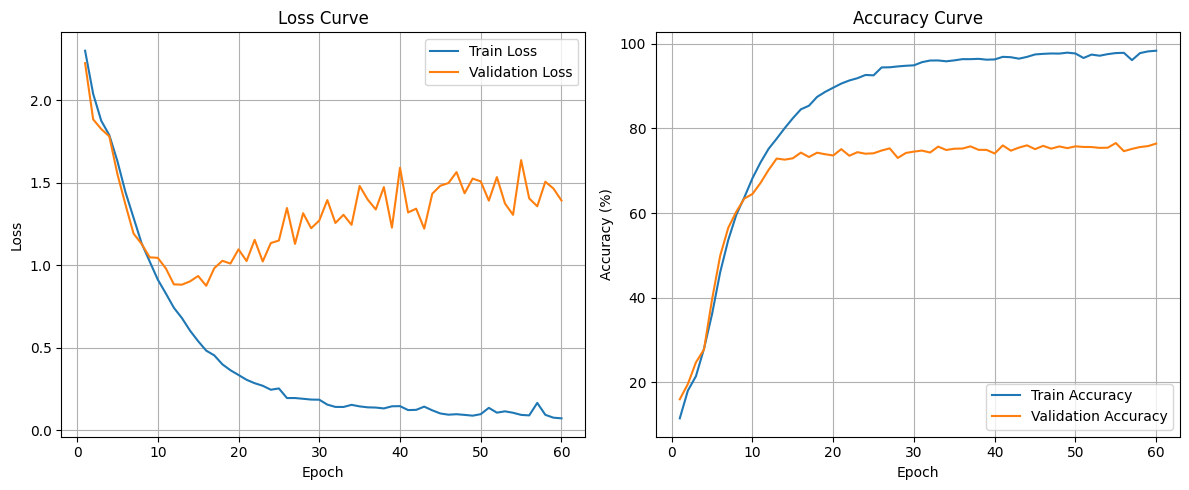

In [39]:
# YOUR CODE HERE

plot_history(history)

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [40]:
# YOUR CODE HERE

test_loss, test_acc = eval_epoch(model, criterion, testloader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Test Loss: 1.4560
Test Accuracy: 76.00%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

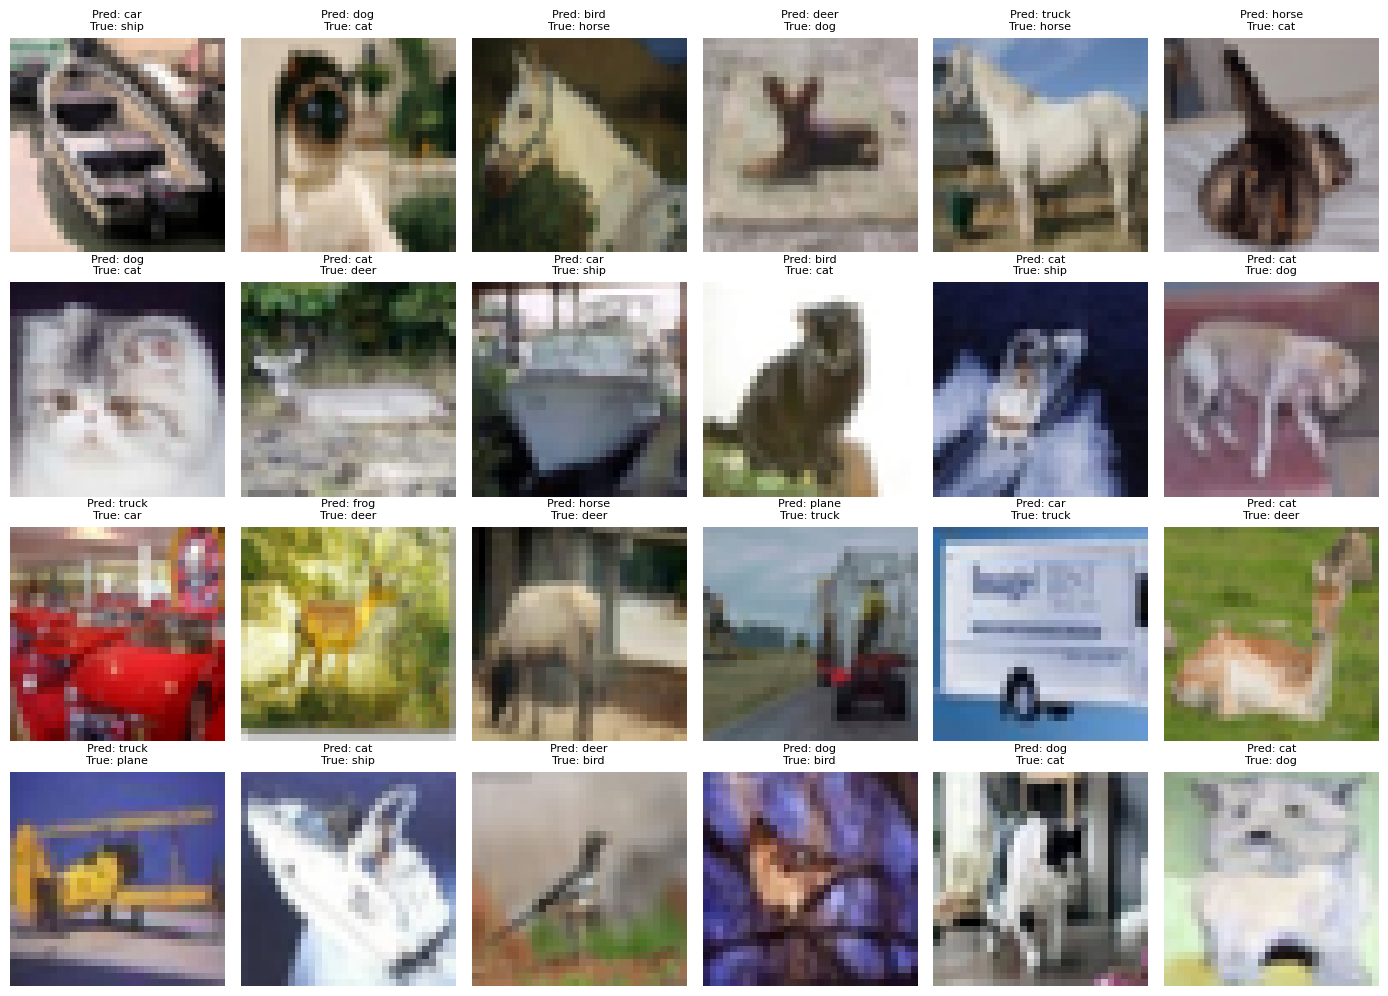

In [42]:
# YOUR CODE HERE

unnormalize = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

model.eval()

misclassified = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

samples = random.sample(misclassified, 24)

fig, axes = plt.subplots(4, 6, figsize=(14, 10))

for ax, (img_tensor, pred, label) in zip(axes.flatten(), samples):
    img = unnormalize(img_tensor).permute(1, 2, 0).clamp(0, 1).numpy()
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[pred]}\nTrue: {classes[label]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [43]:
def get_features(self, x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x

# add this method to CNN
CNN.get_features = get_features

# collect features
model.eval()
all_features = []
all_labels = []

trainloader_feature = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

with torch.no_grad():
    for inputs, labels in trainloader_feature:
        inputs = inputs.to(device)
        features = model.get_features(inputs)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

features_tensor = torch.cat(all_features, dim=0)

print(f"Features tensor shape: {features_tensor.shape}")

Features tensor shape: torch.Size([45000, 512])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

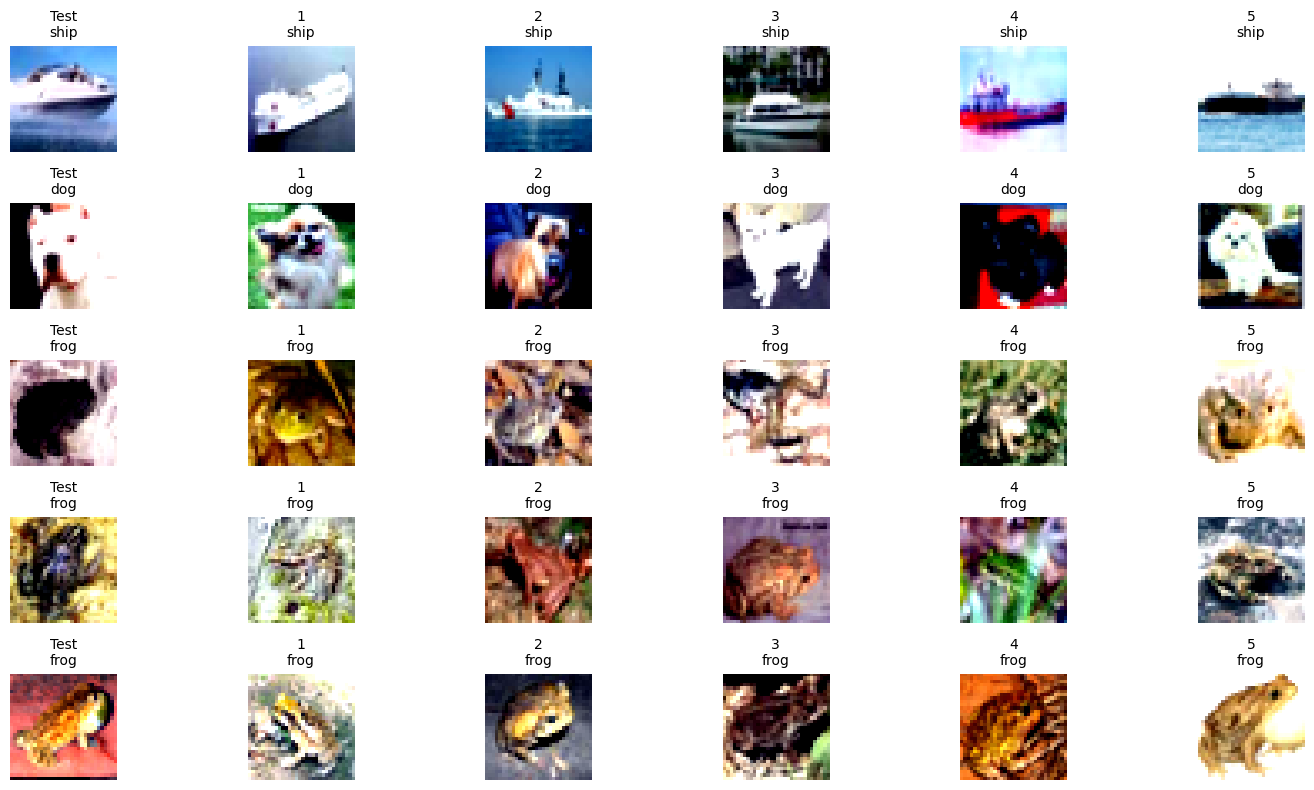

In [44]:
from sklearn.neighbors import NearestNeighbors

# Function to extract features from any dataset
def extract_features(net, dataloader):
    net.eval()
    features_list = []
    labels_list = []
    preds_list = []
    images_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            x = net.features(images)
            x = net.flatten(x)
            features = net.classifier(x)
            outputs = net.linear(features)

            _, preds = torch.max(outputs, 1)

            features_list.append(features.cpu())
            labels_list.append(labels.cpu())
            preds_list.append(preds.cpu())
            images_list.append(images.cpu())

    return (torch.cat(features_list),
            torch.cat(labels_list),
            torch.cat(preds_list),
            torch.cat(images_list))


train_features, train_labels, _, _ = extract_features(model, trainloader_feature)

# Get features for test set
test_features, test_labels, test_preds, test_images = extract_features(model, testloader)

# correctly predicted test
correct_mask = (test_preds == test_labels)
correct_indices = torch.where(correct_mask)[0]

selected_indices = np.random.choice(correct_indices.numpy(), size=5, replace=False)

nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto')
nbrs.fit(train_features.numpy())

# visualization
plt.figure(figsize=(15, 8))
for i, idx in enumerate(selected_indices):
    test_feature = test_features[idx].unsqueeze(0).numpy()
    test_image = test_images[idx]
    test_label = test_labels[idx]

    distances, neighbor_indices = nbrs.kneighbors(test_feature)

    plt.subplot(5, 6, i*6 + 1)
    img = test_image / 2 + 0.5
    img = np.clip(img.numpy(), 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Test\n{classes[test_label]}', fontsize=10)

    for j, neighbor_idx in enumerate(neighbor_indices[0]):
        neighbor_img = trainset[neighbor_idx][0]
        neighbor_label = trainset[neighbor_idx][1]

        plt.subplot(5, 6, i*6 + j + 2)
        img = neighbor_img / 2 + 0.5
        img = np.clip(img.numpy(), 0, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.axis('off')
        plt.title(f'{j+1}\n{classes[neighbor_label]}', fontsize=10)

plt.tight_layout()
plt.show()

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [45]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(features_tensor), 2000)
feature_space = features_tensor[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

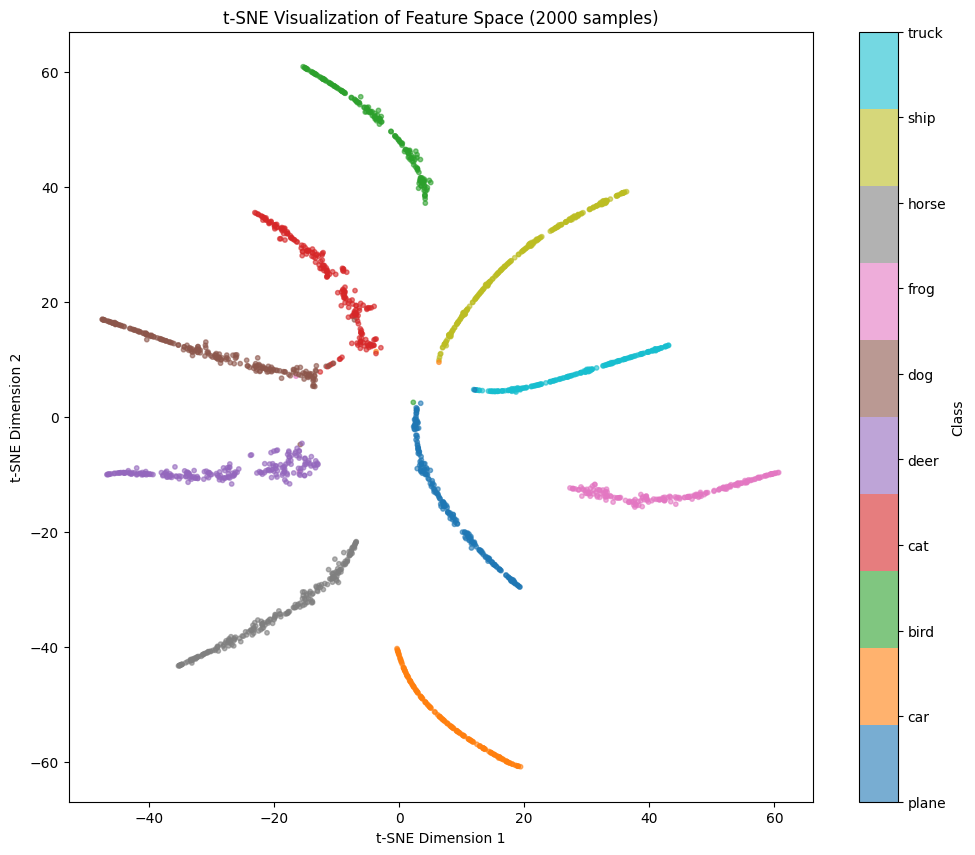

In [46]:
# YOUR CODE HERE

sampled_labels = [trainset[i][1] for i in indices]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    reduced_space[:, 0],
    reduced_space[:, 1],
    c=sampled_labels,
    cmap='tab10',
    alpha=0.6,
    s=10
)

plt.colorbar(scatter, ticks=range(10), label='Class')
plt.title('t-SNE Visualization of Feature Space (2000 samples)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(classes)

plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [47]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```


In [48]:
intermediate_output = None
# YOUR CODE HERE

import torch.nn.functional as F

input_image = image.unsqueeze(0).to(device)

clipped_model = nn.Sequential(
    *list(model.features.children())[:2]
)

with torch.no_grad():
    intermediate_output = clipped_model(input_image)


In [49]:
intermediate_output.shape

torch.Size([1, 128, 32, 32])

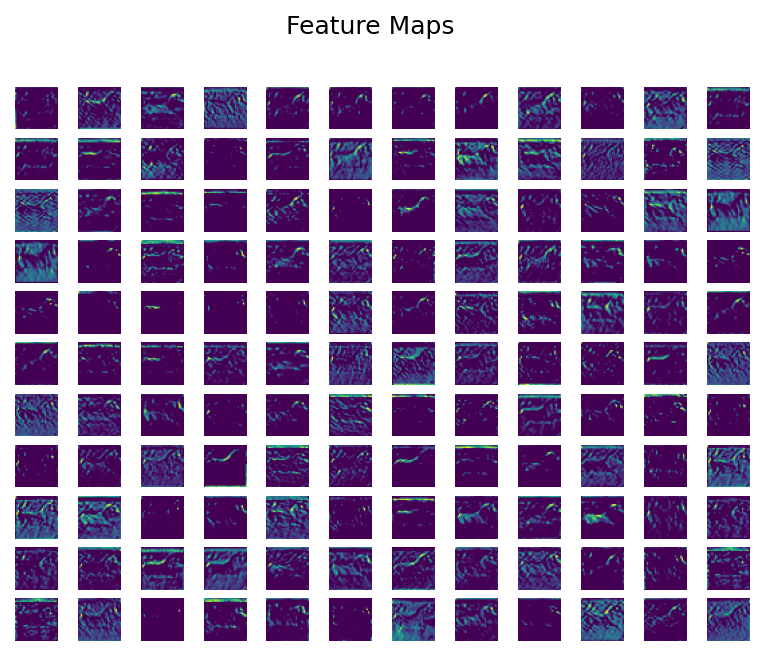

In [50]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
